## notebook imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2

from math import sqrt
sns.set()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
raw_csv = pd.read_csv('Index2018.csv')
df_copy = raw_csv.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'],dayfirst=True)
df_copy.set_index('date',inplace=True)
df_copy = df_copy.asfreq('b')
df_copy = df_copy.fillna(method='ffill')

In [3]:
### Analyzing FTSE column as market_value(price)

df_copy['market_value'] = df_copy['ftse']

In [4]:
df_copy.drop(['spx','dax','ftse','nikkei'],inplace=True,axis=1)

In [5]:
df_copy.head()

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01


### 80-20 Split

In [6]:
size = int(len(df_copy)*0.8)
df = df_copy.iloc[:size]
df_test = df_copy.iloc[size:]

### LLR test

In [26]:
def llr_test(model_1,model_2,df=1):
    ''' can only use this when order of simple model is nested inside the complex model'''
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,df).round(3)
    return p
    

### Creating Returns 

In [8]:
df['returns']=df['market_value'].pct_change(1).mul(100)

<ipython-input-8-51bce0380152>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df['market_value'].pct_change(1).mul(100)


In [9]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


### ARIMA(1,1,1)

In [10]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value,order=(1,1,1))
result_ar_1_i_1_ma_1= model_ar_1_i_1_ma_1.fit()
result_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Tue, 19 Jan 2021   AIC                          55215.333
Time:                        11:21:45   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [11]:
## we have only 2 coeff - beacuse integration order(d) has no effect on number of parameters we need to estimate

## intergration means we are transforming the underlying data while no modelling is performed,, any ARIMA model will
## have same coeff as it's non-integrated counterpart

In [12]:
## the 2. coeff are signifiacantly different than 0, while the constant term is not sig diff than 0

## this was the case with most of the summary tables of the returns, thus integrated time-series
## is more close to returns than prices 

### Residual of ARIMA(1,1,1)

<ipython-input-16-16a98b503a2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_1_i_1_ma_1'] = result_ar_1_i_1_ma_1.resid


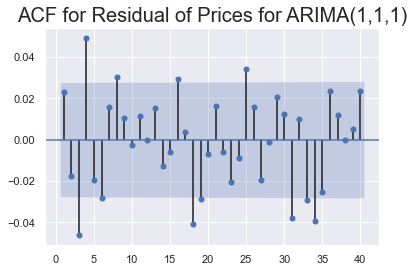

In [16]:
df['res_ar_1_i_1_ma_1'] = result_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:],zero=False,lags=40)
plt.title('ACF for Residual of Prices for ARIMA(1,1,1)',size=20)
plt.show()

In [17]:
# the 3rd and 4th lag are highly significant 
# our prior experience suggest that inclusding these lags into our model might significantly improve performance

In [18]:
## try and see how the model that contains them perform

In [19]:
## ARIMA(1,1,1) - ARIMA(4,1,4)

### Higher Lar ARIMA model

In [20]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
result_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
result_ar_1_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -27600.082
Method:                       css-mle   S.D. of innovations             59.091
Date:                Tue, 19 Jan 2021   AIC                          55210.164
Time:                        11:54:13   BIC                          55242.770
Sample:                    01-10-1994   HQIC                         55221.589
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5657      0.692      0.818      0.413      -0.790       1.922
ar.L1.D.market_value     0.5886      0.100      5.890      0.000       0.393       0.784
ma.L1.D.market_value    -0.6131      0.100     -6.139      0.000      -0.809      -0.417
ma.L2.D.market_value    -0.0457      0.016     -2.864      0.004      -0.077      -0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6990           +0.0000j            1.6990            0.0000
MA.1            1.4699           +0.0000j            1.4699            0.0000
MA.2          -14.8755           +0.0000j           14.8755            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
## fitting only those models that yielded significant p-coeff

model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
result_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()

model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
result_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()

model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
result_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()

model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
result_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

# to prevent from crashing give initial start value greater than AR value (enough starting AR lags for each models)

In [24]:
## let us see which model is good:

print('ARIMA(1,1,1):\t LL =', result_ar_1_i_1_ma_1.llf,"\t AIC = ",result_ar_1_i_1_ma_1.aic)
print('ARIMA(1,1,3):\t LL =', result_ar_1_i_1_ma_3.llf,"\t AIC = ",result_ar_1_i_1_ma_3.aic)
print('ARIMA(2,1,1):\t LL =', result_ar_2_i_1_ma_1.llf,"\t AIC = ",result_ar_2_i_1_ma_1.aic)
print('ARIMA(3,1,1):\t LL =', result_ar_3_i_1_ma_1.llf,"\t AIC = ",result_ar_3_i_1_ma_1.aic)
print('ARIMA(3,1,2):\t LL =', result_ar_3_i_1_ma_2.llf,"\t AIC = ",result_ar_3_i_1_ma_2.aic)






ARIMA(1,1,1):	 LL = -27603.666412766248 	 AIC =  55215.332825532496
ARIMA(1,1,3):	 LL = -27590.424032541097 	 AIC =  55192.848065082195
ARIMA(2,1,1):	 LL = -27599.807487851416 	 AIC =  55209.61497570283
ARIMA(3,1,1):	 LL = -27592.055371698458 	 AIC =  55196.110743396915
ARIMA(3,1,2):	 LL = -27590.66080898272 	 AIC =  55195.32161796544


In [25]:
## shows ARIMA(1,1,3 yields the highest LL and LOWest aic)-- thus front-runner of our shortlist
## since the ARIMA(1,1,2) and ARIMA(1,1,1) is nesed inside this model ,, we need to run LLR test to make sure it
## significanly outperfroms them

In [27]:
print('LLR test P-value\t:',llr_test(model_ar_1_i_1_ma_2,model_ar_1_i_1_ma_3))


LLR test P-value	: 0.0


In [28]:
## this show that higher complexity is necessary

In [30]:
print('LLR test P=value\t: ',llr_test(model_ar_1_i_1_ma_1,model_ar_1_i_1_ma_3,df=2))

LLR test P=value	:  0.0


In [31]:
## this also show complex model to be better

In [32]:
## thus ARIMA(1,1,3) appears to be the best model out of comapred one

In [35]:
## to avoid anaylizg the statistic in vain let us examine the ACF of residuals first:
## only if they resemble whitenoise will we will proceed examinig the parameters,, else we will try to find better 
## fitting model

In [36]:
df['res_ar_1_i_1_ma_3'] = result_ar_1_i_1_ma_3.resid

<ipython-input-36-441d173ed8aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_1_i_1_ma_3'] = result_ar_1_i_1_ma_3.resid


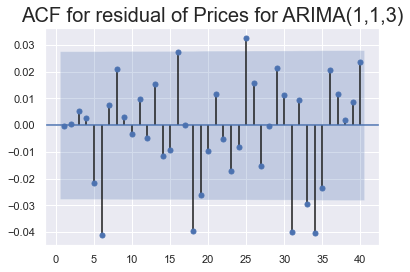

In [39]:
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], lags=40, zero=False)
plt.title('ACF for residual of Prices for ARIMA(1,1,3)', size=20)
plt.show()

In [40]:
## FEWER lags has significant coefficients in comparisoin to simple ARIMA residuals
## however the 6th lag is still highly significant 
## there fore there might exist a better model that goes upto 6 lags back

In [41]:
## thus we should check all models from ARIMA(1,1,1) upto ARIMA(6,1,6) to see if there is a better fit
## should go to 20 different mdeols and their coeff 
## going through all the models only 2 of them yirlded significant values:  ARIMA(6,1,3) and ARIMA(5,1,1)

In [42]:
## previouslt we had ARMA(5,1) as the better fit for price returns thus the fact that ARIMA(5,1,1) is a good estimator
## for prices is not all that surprising -- we are using the same dataset 

In [43]:
## ARIMA(6,1,3) contains Integrated values upto 6 periods ago

In [44]:
## let us try to fit thoise complex models and compare them

In [52]:

model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
result_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit(start_ar_lags=11)


model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6,1,3))
result_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit(start_ar_lags=11)

In [53]:
print('ARIMA(6,1,3):\t LL =', result_ar_6_i_1_ma_3.llf,"\t AIC = ",result_ar_6_i_1_ma_3.aic)
print('ARIMA(5,1,1):\t LL =', result_ar_5_i_1_ma_1.llf,"\t AIC = ",result_ar_5_i_1_ma_1.aic)

print('ARIMA(1,1,3):\t LL =', result_ar_1_i_1_ma_3.llf,"\t AIC = ",result_ar_1_i_1_ma_3.aic)

ARIMA(6,1,3):	 LL = -27583.56532038637 	 AIC =  55189.13064077274
ARIMA(5,1,1):	 LL = -27586.51188811823 	 AIC =  55189.02377623646
ARIMA(1,1,3):	 LL = -27590.424032541097 	 AIC =  55192.848065082195


In [54]:
## ARIMA(6,1,3) is best in both criteria 
## also since ARIMA(5,1,1) and ARIMA(1,1,3) is nested inside ARIMA(6,1,3) let us perfrom LLR test to guarentee
## additional complexity is worth 

In [55]:
print('LLR test p-value: ',llr_test(model_ar_1_i_1_ma_3,model_ar_6_i_1_ma_3,df=5))

LLR test p-value:  0.003


In [56]:
## less than 5% hence the highe complexity is rarionalized beacause it earns sig higher LOG likelihood

In [57]:
print('LLR test p-value',llr_test(model_ar_5_i_1_ma_1,model_ar_6_i_1_ma_3,df=3))


LLR test p-value 0.018


In [59]:
## thus higer model is better at 5%  ## for tutotial got 5,1,1 as better model??

In [60]:
## acf of residuals for model of choice

<ipython-input-63-dffc77771042>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_5_i_1_ma_1'] = result_ar_5_i_1_ma_1.resid


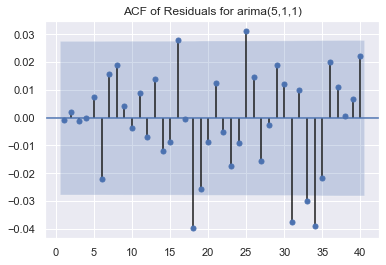

In [63]:
df['res_ar_5_i_1_ma_1'] = result_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:],lags=40,zero=False)
plt.title('ACF of Residuals for arima(5,1,1)')
plt.show()

In [64]:
## shows noone of the first 15 residuals has sig coeff 
## we managed o capture the effect that were incorporated into the 6th lag without direscylt including it into our modell

##we still see some sig coeff many lags into the past --- but the further back in time we go the less relevant the vaue
## becomes

# if we include upto 35 lags we will have white noise residauls but this means overfitting,, we want out model to 
## predict other time series data as well 
## if ovetfit by including too many lags -- model parameter will be too dependent on the data set --no predictive power

In [65]:
result_ar_5_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.512
Method:                       css-mle   S.D. of innovations             58.932
Date:                Tue, 19 Jan 2021   AIC                          55189.024
Time:                        12:43:46   BIC                          55241.193
Sample:                    01-10-1994   HQIC                         55207.305
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5663      0.690      0.820      0.412      -0.787       1.920
ar.L1.D.market_value     0.4011      0.159      2.529      0.011       0.090       0.712
ar.L2.D.market_value    -0.0445      0.016     -2.856      0.004      -0.075      -0.014
ar.L3.D.market_value    -0.0543      0.017     -3.163      0.002      -0.088      -0.021
ar.L4.D.market_value     0.0586      0.019      3.069      0.002       0.021       0.096
ar.L5.D.market_value    -0.0581      0.014     -4.118      0.000      -0.086      -0.030
ma.L1.D.market_value    -0.4213      0.158     -2.659      0.008      -0.732      -0.111
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7609           -0.0000j            1.7609           -0.5000
AR.2            1.4633           -0.8605j            1.6975           -0.0846
AR.3            1.4633           +0.8605j            1.6975            0.0846
AR.4           -0.0790           -1.8393j            1.8410           -0.2568
AR.5           -0.0790           +1.8393j            1.8410            0.2568
MA.1            2.3735           +0.0000j            2.3735            0.0000
-----------------------------------------------------------------------------
"""

In [66]:
## all coeff are sig at 5% cofidence 

In [68]:
 ## until now we have assumed the best model would requiure only a single layer of integration -- but what if better
## model exist with more layers of integration ?? 

### Model with higher level of Integration

In [69]:
## we rely on integration when our time series data does not come froma a stationary process

In [71]:
df['delta_prices'] = df.market_value.diff(1) ## the difference between value 1 period apart
# first row will have no data as it has no prioir value -- thus should ignore it for any model testing

<ipython-input-71-056b21bee48a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_prices'] = df.market_value.diff(1) ## the difference between value 1 period apart


In [72]:
## let us fit ARMA(1,1) ot the delta_prices and see if it is equ to ARIMA(1,0,1)

In [73]:
model_delta_ar_1_i_0_ma_1 = ARIMA(df.delta_prices[1:],order=(1,0,1))
result_delta_ar_1_i_0_ma_1 = model_delta_ar_1_i_0_ma_1.fit()
result_delta_ar_1_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Tue, 19 Jan 2021   AIC                          55215.333
Time:                        13:06:02   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.delta_prices     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.delta_prices    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [74]:
# this should be same as ARIMA(1,1,1) for the prices without intergration(original price)

In [75]:
result_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Tue, 19 Jan 2021   AIC                          55215.333
Time:                        13:07:00   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5656      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

In [76]:
## they have identical coeff and p-values 

In [77]:
## let us go for augmented df test to check fot stationarity of the data

In [78]:
sts.adfuller(df.delta_prices[1:])

(-32.24409349570747,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

In [82]:
# absolute(test-statistic)=32.24 > critical 1 % value
# the p-val is 0.0 
## thus we ge the confirmatio of stationarity

## no need additional layer of intergration
# fitting ARIMA model with d>1 is not-recommended

In [81]:
'''
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.'''

'\np-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.\n\np-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.'